In [42]:
from wrangle import *
from env import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# Clustering

### 1. Dataset

In [74]:
url = get_db_url('titanic_db')

query = '''
            SELECT *
            FROM passengers
        '''

df = pd.read_sql(query,url)

In [75]:
handle_missing_values(df,.8,.9)

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,Southampton,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,886,0,2,male,27.0,0,0,13.0000,S,Second,Southampton,1
887,887,1,1,female,19.0,0,0,30.0000,S,First,Southampton,1
888,888,0,3,female,NaN,1,2,23.4500,S,Third,Southampton,0
889,889,1,1,male,26.0,0,0,30.0000,C,First,Cherbourg,1


### Impute Nulls

In [76]:
dataset_nulls_imputer_mean = SimpleImputer(missing_values = np.nan, strategy='mean')
df[['age']] = dataset_nulls_imputer_mean.fit_transform(df[['age']])

In [85]:
train,val,test = split_data(df)

### 2. Feature Select, Scale, Cluster Count

In [86]:
features=['fare','age']

In [87]:
cluster_count = 3

In [88]:
X = train[features]

In [91]:
X.head()

,fare,age
376,0.014151,0.271174
458,0.020495,0.623021
732,0.000000,0.367204
507,0.051822,0.367204
830,0.028213,0.183212


In [89]:
mm_scaler = MinMaxScaler()
X[features] = mm_scaler.fit_transform(X[features])

/var/folders/_r/wftd7dk93nj_hbzpqfw4vnsr0000gn/T/ipykernel_32639/3945616373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[features] = mm_scaler.fit_transform(X[features])


In [90]:
seed = 42
kmeans = KMeans(n_clusters=cluster_count,random_state=seed)
kmeans.fit(X)

KMeans(n_clusters=3, random_state=42)

In [92]:
train['clusters']=kmeans.predict(X)
train.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,embark_town,alone,clusters
376,376,1,3,female,22.000000,0,0,7.2500,S,Third,Southampton,1,0
458,458,1,2,female,50.000000,0,0,10.5000,S,Second,Southampton,1,2
732,732,0,2,male,29.642093,0,0,0.0000,S,Second,Southampton,1,0
507,507,1,1,male,29.642093,0,0,26.5500,S,First,Southampton,1,0
830,830,1,3,female,15.000000,1,0,14.4542,C,Third,Cherbourg,0,1


### 3. Visualize Clusters

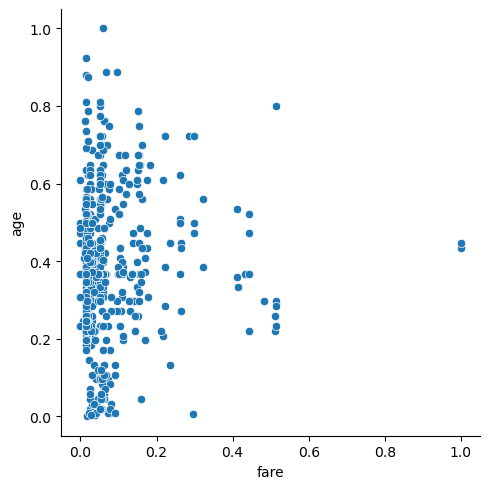

In [93]:
sns.relplot(data=X,x=features[0],y=features[1])

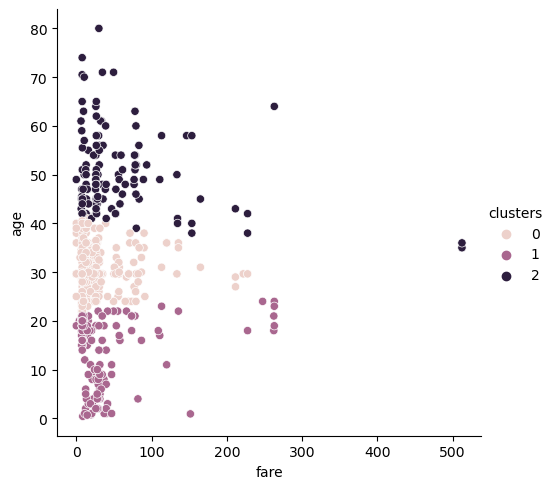

In [95]:
sns.relplot(data=train,x=features[0],y=features[1],hue='clusters')

### 4. Cluster Centers

In [96]:
cluster_centers = kmeans.cluster_centers_

In [97]:
cluster_centers

array([[0.04596819, 0.37045473],
       [0.06898154, 0.17373619],
       [0.10781089, 0.62603669]])

In [98]:
cluster_centers.shape

(3, 2)

In [99]:
X.columns

Index(['fare', 'age'], dtype='object')

In [100]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,fare,age
0,0.045968,0.370455
1,0.068982,0.173736
2,0.107811,0.626037


In [103]:
train.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,embark_town,alone,clusters
376,376,1,3,female,22.000000,0,0,7.2500,S,Third,Southampton,1,0
458,458,1,2,female,50.000000,0,0,10.5000,S,Second,Southampton,1,2
732,732,0,2,male,29.642093,0,0,0.0000,S,Second,Southampton,1,0
507,507,1,1,male,29.642093,0,0,26.5500,S,First,Southampton,1,0
830,830,1,3,female,15.000000,1,0,14.4542,C,Third,Cherbourg,0,1


/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


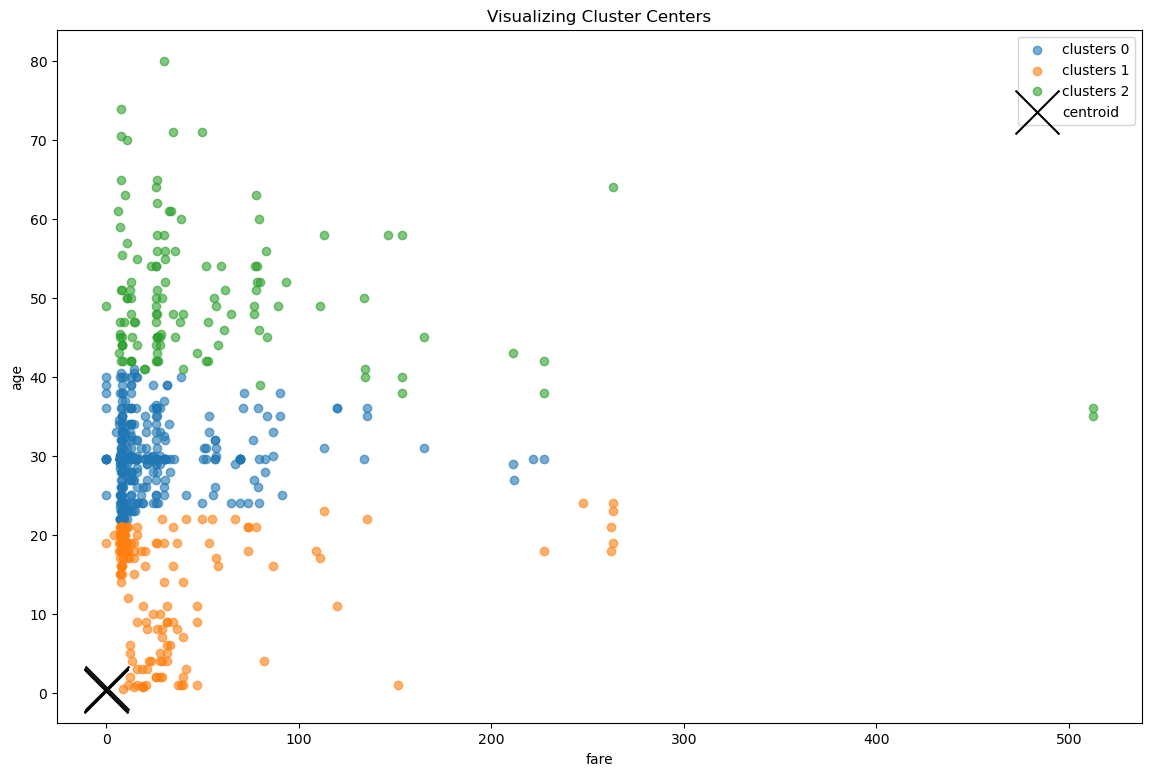

In [104]:
plt.figure(figsize=(14, 9))

for cluster, subset in train.groupby('clusters'):
    plt.scatter(subset['fare'], subset['age'], label='clusters ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='age', x='fare', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('fare')
plt.ylabel('age')
plt.title('Visualizing Cluster Centers')
plt.show()

### 5. New Cluster Count

In [ ]:
kmeans = KMeans(n_clusters=5).fit(X)
iris['cluster'] = kmeans.predict(X)
iris.cluster = 'cluster_' + (iris.cluster + 1).astype('str')
sns.relplot(data=iris,x='petal_width',y='sepal_width',hue='cluster')

### 6.  Elbow

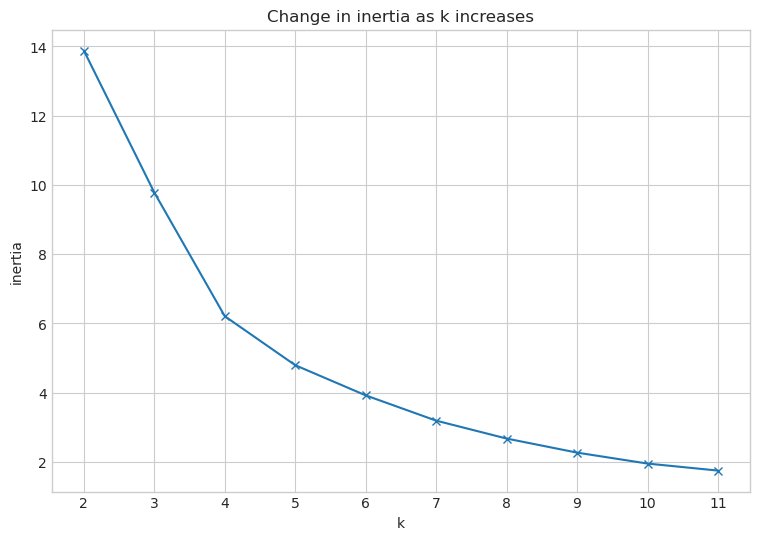

In [106]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

### 7. Loop Cluster Count

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X).predict(X)
    ax.scatter(X['sepal_width'], X['petal_width'], c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='sepal width', ylabel='petal width')